In [3]:
import os
import glob
import napari
import pandas as pd
import numpy as np
import mahotas as mh

from pathlib import Path
from aicsimageio import AICSImage, readers
from blimp.preprocessing.illumination_correction import IlluminationCorrection

from PIL import Image
from matplotlib import cm

data_dir = "/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240304/240301_ARMC5KO_EU"
image_dir = os.path.join(data_dir,"20240304_180009_911/OME-TIFF-MIP")
label_image_dir = os.path.join(data_dir,"20240304_180009_911/SEGMENTATION")

ana_dir = "/srv/scratch/z3532965/src/publications/2024_ARMC5/hek_inhibitors_EU"
illum_corr_file = os.path.join(data_dir,"/srv/scratch/berrylab/z3532965/NikonSpinningDisk/240304/ILLUMCORR/illumination_correction.pkl")

In [4]:
def create_overlay_image_plot(
        channel_image, label_image,
        color='rgb(255, 191, 0)', thin=False):

    # threshold label_image and generate outlines
    label_image = np.array(label_image)
    if (thin):
        outlines = mh.labeled.borders(label_image) * 255
    else:
        outlines = mh.morph.dilate(mh.labeled.borders(label_image)) * 255
    overlay = Image.fromarray(np.uint8(outlines))
    outlines_transparent = Image.new(
        mode='RGBA', size=outlines.shape[::-1], color=(0, 0, 0, 0)
    )

    channel_image = channel_image.convert("RGBA")
    outlines_transparent.paste(channel_image, (0,0))
    outlines_transparent.paste(overlay, (0,0), mask=overlay)

    return outlines_transparent

## Load metadata
We have a csv file of the plate layout that includes information on antibody staining

In [5]:
import re

plate_layout = pd.read_csv(os.path.join(ana_dir,"METADATA","240301_ARMC5KO_EU_longlayout.csv"))
plate_layout.columns

def pad_well_names(name):
    return re.sub(r'(\D)(\d)$', r'\g<1>0\2', name)

# Apply the function to the DataFrame column in place
plate_layout['Well name'] = plate_layout['Well name'].apply(lambda x: pad_well_names(x))

## Apply illumination correction

Load illumination correction object

In [6]:
illumination_correction = IlluminationCorrection(from_file=illum_corr_file)

## Join image metadata and plate layout

In [7]:
image_metadata_files = glob.glob(os.path.join(image_dir,"*.csv"))
image_metadata = pd.concat((pd.read_csv(f) for f in image_metadata_files), ignore_index=True)
image_metadata['well_name'] = image_metadata['filename_ome_tiff'].str.extract(r'Well([A-Z]\d{2})_Channel')
image_metadata.columns

Index(['n_pixels_y', 'n_pixels_x', 'objective_name', 'pixel_size_microns',
       'field_id', 'timepoint_id', 'filename_ome_tiff', 'acquisition_time_rel',
       'stage_y_abs', 'stage_x_abs', 'stage_z_n', 'acquisition_time_abs',
       'standard_field_id', 'metadata_string_acquisition_0',
       'metadata_string_acquisition_1', 'metadata_string_acquisition_2',
       'metadata_string_acquisition_3', 'well_name'],
      dtype='object')

In [8]:
image_metadata_annotated = image_metadata.merge(plate_layout,left_on="well_name", right_on="Well name")

In [9]:
image_metadata_annotated.query(
    "`EU concentration` == '100 µM' and Cell == 'HEK293 parental' and Drug == 'Vehicle' and field_id == 1")

,n_pixels_y,n_pixels_x,objective_name,pixel_size_microns,field_id,timepoint_id,filename_ome_tiff,acquisition_time_rel,stage_y_abs,stage_x_abs,...,metadata_string_acquisition_1,metadata_string_acquisition_2,metadata_string_acquisition_3,well_name,Well name,Cell,Drug,Drug time,EU concentration,EU time
27,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellI08_ChannelMono,Mono,Mono,488_Seq0077_0001...",34551.006453,1818.652381,20937.0,...,Plane #2:\n Name: Mono\n Component Count: 1\n ...,Plane #3:\n Name: Mono\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,I08,I08,HEK293 parental,Vehicle,120 min,100 µM,30 min
99,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellL08_ChannelMono,Mono,Mono,488_Seq0096_0001...",43073.065284,15283.519048,20931.4,...,Plane #2:\n Name: Mono\n Component Count: 1\n ...,Plane #3:\n Name: Mono\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,L08,L08,HEK293 parental,Vehicle,120 min,100 µM,30 min
459,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellC08_ChannelMono,Mono,Mono,488_Seq0005_0001...",2264.746980,-25111.066667,20948.0,...,Plane #2:\n Name: Mono\n Component Count: 1\n ...,Plane #3:\n Name: Mono\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,C08,C08,HEK293 parental,Vehicle,120 min,100 µM,15 min
567,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellF08_ChannelMono,Mono,Mono,488_Seq0042_0001...",18854.891970,-11646.323810,20942.4,...,Plane #2:\n Name: Mono\n Component Count: 1\n ...,Plane #3:\n Name: Mono\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,F08,F08,HEK293 parental,Vehicle,120 min,100 µM,15 min
621,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellF14_ChannelMono,Mono,Mono,488_Seq0036_0001...",16162.851027,-11637.700000,-6053.2,...,Plane #2:\n Name: Mono\n Component Count: 1\n ...,Plane #3:\n Name: Mono\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,F14,F14,HEK293 parental,Vehicle,120 min,100 µM,60 min
846,2304,2304,Plan Apo λ 40x,0.1625,1,0,"WellC14_ChannelMono,Mono,Mono,488_Seq0011_0001...",4954.571633,-25102.761905,-6047.5,...,Plane #2:\n Name: Mono\n Component Count: 1\n ...,Plane #3:\n Name: Mono\n Component Count: 1\n ...,Plane #4:\n Name: 488\n Component Count: 1\n M...,C14,C14,HEK293 parental,Vehicle,120 min,100 µM,60 min


## Save Examples

In [10]:
example_images = image_metadata_annotated.query("field_id == 3 and `EU time` == '30 min'")[['filename_ome_tiff','EU concentration','EU time','Cell','Drug','well_name']]
example_images['new_filename'] = example_images['Cell'] + '_' + example_images['Drug'] + '_EU' + example_images['EU concentration'] + '_' + example_images['EU time'] + example_images['well_name'] + '.png'
example_images['new_filename_overlay'] = example_images['Cell'] + '_' + example_images['Drug'] + '_EU' + example_images['EU concentration'] + '_' + example_images['EU time'] + example_images['well_name'] + '_nuclei.png'
example_images['filename_segmentation'] = 'nuclei_' + example_images['filename_ome_tiff']
example_images['intensity_rescaling_group']='A'

In [11]:
example_images

,filename_ome_tiff,EU concentration,EU time,Cell,Drug,well_name,new_filename,new_filename_overlay,filename_segmentation,intensity_rescaling_group
2,"WellN07_ChannelMono,Mono,Mono,488_Seq0109_0003...",100 µM,30 min,HEK293 ARMC5 KO 2B6,DRB 100 µM,N07,HEK293 ARMC5 KO 2B6_DRB 100 µM_EU100 µM_30 min...,HEK293 ARMC5 KO 2B6_DRB 100 µM_EU100 µM_30 min...,"nuclei_WellN07_ChannelMono,Mono,Mono,488_Seq01...",A
11,"WellN08_ChannelMono,Mono,Mono,488_Seq0108_0003...",100 µM,30 min,HEK293 ARMC5 KO 2B6,Vehicle,N08,HEK293 ARMC5 KO 2B6_Vehicle_EU100 µM_30 minN08...,HEK293 ARMC5 KO 2B6_Vehicle_EU100 µM_30 minN08...,"nuclei_WellN08_ChannelMono,Mono,Mono,488_Seq01...",A
20,"WellK07_ChannelMono,Mono,Mono,488_Seq0094_0003...",100 µM,30 min,HEK293 ARMC5 KO 2B6,DRB 100 µM,K07,HEK293 ARMC5 KO 2B6_DRB 100 µM_EU100 µM_30 min...,HEK293 ARMC5 KO 2B6_DRB 100 µM_EU100 µM_30 min...,"nuclei_WellK07_ChannelMono,Mono,Mono,488_Seq00...",A
29,"WellI08_ChannelMono,Mono,Mono,488_Seq0077_0003...",100 µM,30 min,HEK293 parental,Vehicle,I08,HEK293 parental_Vehicle_EU100 µM_30 minI08.png,HEK293 parental_Vehicle_EU100 µM_30 minI08_nuc...,"nuclei_WellI08_ChannelMono,Mono,Mono,488_Seq00...",A
65,"WellK03_ChannelMono,Mono,Mono,488_Seq0090_0003...",100 µM,30 min,HEK293 ARMC5 KO 2B6,LDC4297 10 µM,K03,HEK293 ARMC5 KO 2B6_LDC4297 10 µM_EU100 µM_30 ...,HEK293 ARMC5 KO 2B6_LDC4297 10 µM_EU100 µM_30 ...,"nuclei_WellK03_ChannelMono,Mono,Mono,488_Seq00...",A
74,"WellI04_ChannelMono,Mono,Mono,488_Seq0073_0003...",100 µM,30 min,HEK293 parental,THZ1 1 µM,I04,HEK293 parental_THZ1 1 µM_EU100 µM_30 minI04.png,HEK293 parental_THZ1 1 µM_EU100 µM_30 minI04_n...,"nuclei_WellI04_ChannelMono,Mono,Mono,488_Seq00...",A
83,"WellM05_ChannelMono,Mono,Mono,488_Seq0104_0003...",100 µM,30 min,HEK293 ARMC5 KO 1A3,Triptolide 300 nM,M05,HEK293 ARMC5 KO 1A3_Triptolide 300 nM_EU100 µM...,HEK293 ARMC5 KO 1A3_Triptolide 300 nM_EU100 µM...,"nuclei_WellM05_ChannelMono,Mono,Mono,488_Seq01...",A
92,"WellL06_ChannelMono,Mono,Mono,488_Seq0098_0003...",100 µM,30 min,HEK293 parental,AZD4573 1 µM,L06,HEK293 parental_AZD4573 1 µM_EU100 µM_30 minL0...,HEK293 parental_AZD4573 1 µM_EU100 µM_30 minL0...,"nuclei_WellL06_ChannelMono,Mono,Mono,488_Seq00...",A
101,"WellL08_ChannelMono,Mono,Mono,488_Seq0096_0003...",100 µM,30 min,HEK293 parental,Vehicle,L08,HEK293 parental_Vehicle_EU100 µM_30 minL08.png,HEK293 parental_Vehicle_EU100 µM_30 minL08_nuc...,"nuclei_WellL08_ChannelMono,Mono,Mono,488_Seq00...",A
110,"WellL07_ChannelMono,Mono,Mono,488_Seq0097_0003...",100 µM,30 min,HEK293 parental,DRB 100 µM,L07,HEK293 parental_DRB 100 µM_EU100 µM_30 minL07.png,HEK293 parental_DRB 100 µM_EU100 µM_30 minL07_...,"nuclei_WellL07_ChannelMono,Mono,Mono,488_Seq00...",A


In [12]:
from pathlib import Path
example_dir = Path(image_dir).parent / 'EXAMPLES' / 'RGB'
example_overlay_dir = Path(image_dir).parent / 'EXAMPLES' / 'RGB_OVERLAY'
if not example_dir.exists(): 
    example_dir.mkdir(parents=True)
if not example_overlay_dir.exists(): 
    example_overlay_dir.mkdir(parents=True)

In [13]:
%%capture
example_images_grouped = example_images.groupby('intensity_rescaling_group')
upper_rescale_values = {}
for group_name, group_data in example_images_grouped:
    group_of_image_files = group_data['filename_ome_tiff'].to_list()
    upper_rescale_value = []
    for image_filename in group_of_image_files:
        aics_image = AICSImage(Path(image_dir) / image_filename, reader=readers.ome_tiff_reader.OmeTiffReader )
        aics_image = illumination_correction.correct(aics_image)
        EU_array = aics_image.get_image_data('YX',Z=0,C=0,T=0)[500:,:] # crop
        upper_rescale_value.append(np.quantile(EU_array,0.90))
    upper_rescale_values[group_name] = max(upper_rescale_value)

In [14]:
upper_rescale_values_df = pd.DataFrame(upper_rescale_values.items(), columns=['intensity_rescaling_group','upper_rescale_value'])
upper_rescale_values_df
example_images = example_images.merge(upper_rescale_values_df,on="intensity_rescaling_group")

In [15]:
%%capture
for index, row in example_images.iterrows():
    aics_image = AICSImage(Path(image_dir) / row["filename_ome_tiff"], reader=readers.ome_tiff_reader.OmeTiffReader)
    aics_image = illumination_correction.correct(aics_image)
    EU_array = aics_image.get_image_data('YX',Z=0,C=0,T=0)[:,500:] # crop
    lower_rescale_value = 150
    EU_array_rescaled = (EU_array.astype(float) - lower_rescale_value) / row["upper_rescale_value"]
    pil_image = Image.fromarray(cm.magma(EU_array_rescaled.clip(0,1),bytes=True)).convert('RGB')
    pil_image.save(str(example_dir / row["new_filename"]), quality=100, subsampling=0)
    
    # add segmentation overlay
    segmentation_aics_image = AICSImage(Path(label_image_dir) / row["filename_segmentation"], reader=readers.ome_tiff_reader.OmeTiffReader)
    segmentation_array = segmentation_aics_image.get_image_data('YX',Z=0,C=0,T=0) # already cropped
    segmentation_pil_image = Image.fromarray(segmentation_array)
    overlay_image = create_overlay_image_plot(pil_image,segmentation_pil_image,thin=True)
    overlay_image.save(str(example_overlay_dir / row["new_filename_overlay"]), quality=100, subsampling=0)

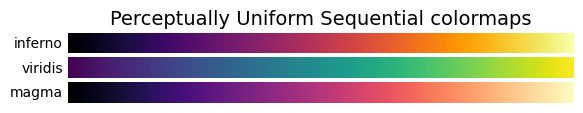

In [16]:
import matplotlib.pyplot as plt
import numpy as np

cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Cyclic', ['twilight', 'twilight_shifted', 'hsv']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar'])]

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

def plot_color_gradients(cmap_category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows-1)*0.1)*0.22
    fig, axs = plt.subplots(nrows=nrows, figsize=(6.4, figh))
    fig.subplots_adjust(top=1-.35/figh, bottom=.15/figh, left=0.2, right=0.99)

    axs[0].set_title(f"{cmap_category} colormaps", fontsize=14)

    for ax, cmap_name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=cmap_name)
        ax.text(-.01, .5, cmap_name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()
        
    return fig


colormaps = plot_color_gradients('Perceptually Uniform Sequential', ['inferno','viridis','magma'])

colormaps.savefig(str(Path(image_dir).parent / 'EXAMPLES' / 'colormap.png'))